In [1]:
import pandas as pd
from IPython.display import display                
import numpy as np  #for mathematical calculation
import seaborn as sns   #for data visualization
import matplotlib.pyplot as plt # for plotting graphs
import missingno as msno
%matplotlib inline

#sklearn package for model implementation
from statsmodels.stats import weightstats as stests
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,f1_score

import warnings
warnings.filterwarnings("ignore")


ModuleNotFoundError: No module named 'missingno'

In [2]:
clean_Loan_data = pd.read_csv(r"C:\Users\odeda\OneDrive\Desktop\Marketing\Loan\Loan.csv")
clean_Loan_data.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
clean_Loan_data.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [4]:
clean_Loan_data.shape

(614, 13)

In [6]:
clean_Loan_data = clean_Loan_data.dropna()

In [7]:
clean_Loan_data.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [8]:
clean_Loan_data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,480.000000,480.000000,480.000000,480.000000,480.000000
mean,5364.231250,1581.093583,144.735417,342.050000,0.854167
std,5668.251251,2617.692267,80.508164,65.212401,0.353307
min,150.000000,0.000000,9.000000,36.000000,0.000000
25%,2898.750000,0.000000,100.000000,360.000000,1.000000
50%,3859.000000,1084.500000,128.000000,360.000000,1.000000
75%,5852.500000,2253.250000,170.000000,360.000000,1.000000
max,81000.000000,33837.000000,600.000000,480.000000,1.000000


# Observation 

The mean applicant income is around $5364.23

The minimum value for applicant income is $150 which is very small and could be an outlier since it is very far from both the mean and the median.

There are a good number of co applicants with no income, as can be observed by thet fact that the 25% quantile of coapplicants have an income of 0.

In [9]:
clean_Loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 1 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            480 non-null    object 
 1   Gender             480 non-null    object 
 2   Married            480 non-null    object 
 3   Dependents         480 non-null    object 
 4   Education          480 non-null    object 
 5   Self_Employed      480 non-null    object 
 6   ApplicantIncome    480 non-null    int64  
 7   CoapplicantIncome  480 non-null    float64
 8   LoanAmount         480 non-null    float64
 9   Loan_Amount_Term   480 non-null    float64
 10  Credit_History     480 non-null    float64
 11  Property_Area      480 non-null    object 
 12  Loan_Status        480 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 52.5+ KB


# Exploratory Data Analysis

Univariate Visual Analysis Target Variable - Loan Status


In [10]:
clean_Loan_data = clean_Loan_data.drop(columns=['Loan_ID']) ## Dropping Loan ID
categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

print(categorical_columns)
numerical_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
print(numerical_columns)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


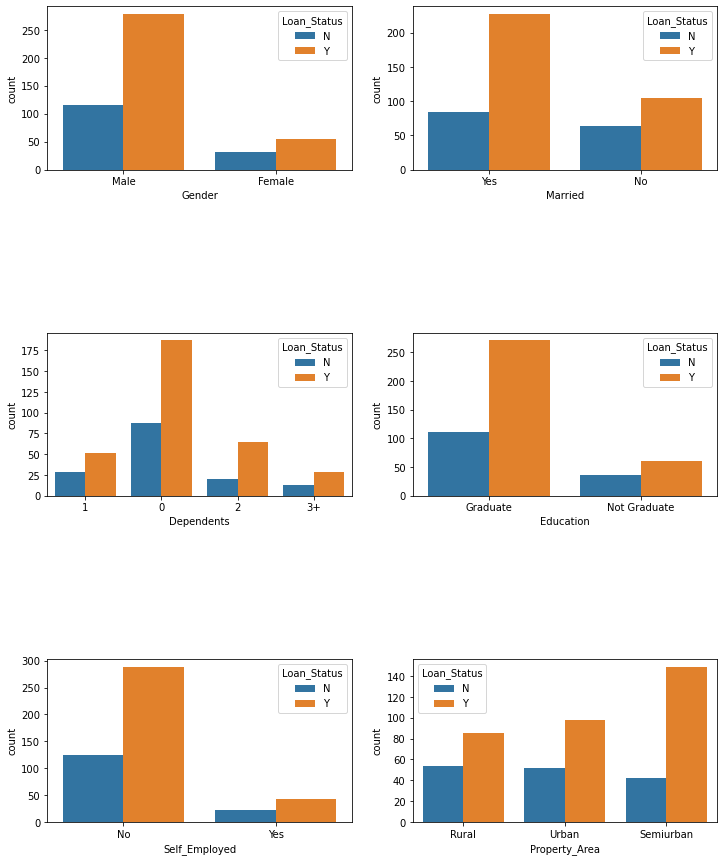

In [11]:


fig,axes = plt.subplots(3,2,figsize=(12,15))
for idx,cat_col in enumerate(categorical_columns):
    row,col = idx//2,idx%2
    sns.countplot(x = cat_col, data = clean_Loan_data, hue = 'Loan_Status', ax = axes[row,col])


plt.subplots_adjust(hspace=1)

Plots above convey following things about the dataset:
Loan Approval Status: About 2/3rd of applicants have been granted loan.
Sex: There are more Men than Women (approx. 3x)
Martial Status: 2/3rd of the population in the dataset is Marred; Married applicants are more likely to be granted loans.
Dependents: Majority of the population have zero dependents and are also likely to accepted for loan.
Education: About 5/6th of the population is Graduate and graduates have higher propotion of loan approval
Employment: 5/6th of population is not self employed.
Property Area: More applicants from Semi-urban and also likely to be granted loans.
Applicant with credit history are far more likely to be accepted.
Loan Amount Term: Majority of the loans taken are for 360 Months (30 years).
Now, let's also analyze Numerical Columns:

       ApplicantIncome  CoapplicantIncome  LoanAmount
count       480.000000         480.000000  480.000000
mean       5364.231250        1581.093583  144.735417
std        5668.251251        2617.692267   80.508164
min         150.000000           0.000000    9.000000
25%        2898.750000           0.000000  100.000000
50%        3859.000000        1084.500000  128.000000
75%        5852.500000        2253.250000  170.000000
max       81000.000000       33837.000000  600.000000


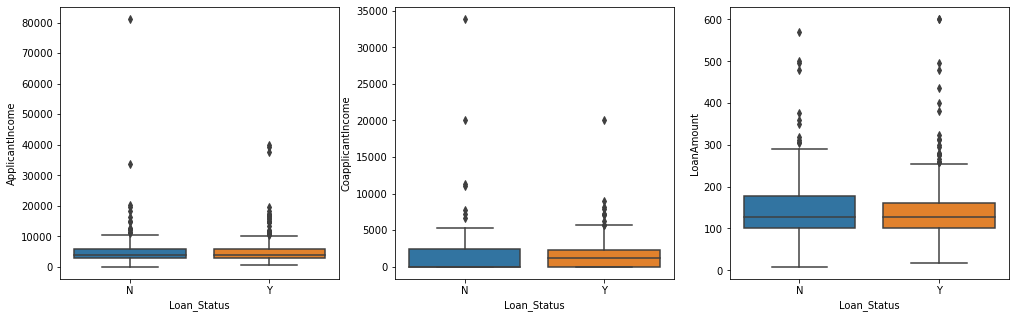

In [13]:
fig,axes = plt.subplots(1,3,figsize=(17,5))
for idx,cat_col in enumerate(numerical_columns):
    sns.boxplot(y=cat_col, data = clean_Loan_data, x='Loan_Status', ax=axes[idx])

print(clean_Loan_data[numerical_columns].describe())
plt.subplots_adjust(hspace=1)

For Numercical Columns, there is no significant relation to Loan approval status.

# Co-Rrelation 

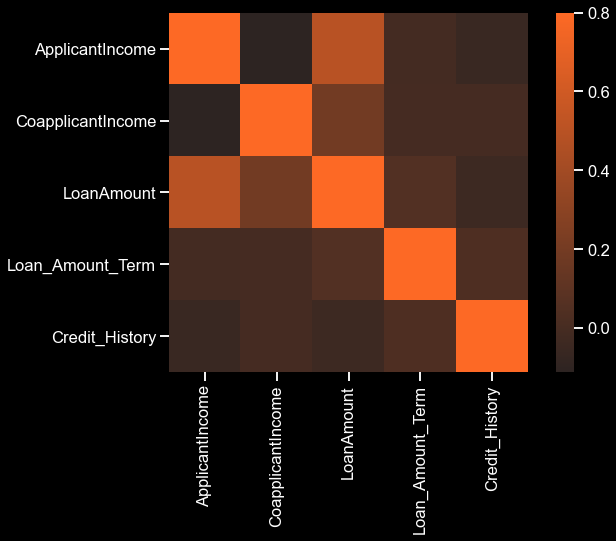

In [24]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
matrix = clean_Loan_data.corr() 
fig, ax = plt.subplots(figsize=(9,6))
cmap = sns.dark_palette("#fd6925", as_cmap=True)
fig.tight_layout()
HeatM = sns.heatmap(matrix,vmax=.8,square=True, cmap=cmap)
plt.rcParams['figure.figsize']=(10,10)
fig = HeatM.get_figure()
fig.savefig('output.png', transparent=True)

In [25]:
corr = clean_Loan_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
ApplicantIncome,1.00,-0.11,0.50,-0.01,-0.06
CoapplicantIncome,-0.11,1.00,0.19,-0.01,-0.01
LoanAmount,0.50,0.19,1.00,0.05,-0.04
Loan_Amount_Term,-0.01,-0.01,0.05,1.00,0.03
Credit_History,-0.06,-0.01,-0.04,0.03,1.00


We can clearly see that ApplicantIncome has the highest correlation with Loan_Status (a positive correlation of 0.50) followed by Coapplicantincome (0.19 correlation). Therefore our target value is highly dependant on this column

# Preprocessing Data:

Input data needs to be pre-processed before we feed it to model. Following things need to be taken care:

1 Encoding Categorical Features.
2 Imputing missing values

In [13]:
# Encoding categrical Features:
# Here I am removing every dummies / repeated values

clean_Loan_data_encoded = pd.get_dummies(clean_Loan_data, drop_first=True)
clean_Loan_data_encoded.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Married_Yes,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y
1,4583,1508.0,128.0,360.0,1.0,1,1,1,0,0,0,0,0,0,0
2,3000,0.0,66.0,360.0,1.0,1,1,0,0,0,0,1,0,1,1
3,2583,2358.0,120.0,360.0,1.0,1,1,0,0,0,1,0,0,1,1
4,6000,0.0,141.0,360.0,1.0,1,0,0,0,0,0,0,0,1,1
5,5417,4196.0,267.0,360.0,1.0,1,1,0,1,0,0,1,0,1,1


# Random Forest Classifier

#### Now I am Building Prediction Model for predicting Loan status. Which means my model is will be predict the Loan approvel status. Here I am using Random Forest Regressor Model. I choose this model because I think for this dataset this is the best model. It has lot of Advantes like it uses averaging to improve the predictive accuracy and control over-fitting.

In [14]:
# Split Features and Target Varible 

#columns Loan_Status_Y is my target variable for predicition. So I remove it from feature
X = clean_Loan_data_encoded.drop(columns='Loan_Status_Y')
y = clean_Loan_data_encoded['Loan_Status_Y'] #Add target variable Loan_Status_Y in variable y

#Splitting into Train-Test Data 
#here I decided to split the data.
#80% data goes for training and and rest 20% data will be used as testing
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.2, stratify = y, random_state = 42)

In [19]:
#here to improve the accuracy of model I add few parameter to model like n_estimators,max_depth and min_samples_leaf
model_rfr = RandomForestClassifier(n_estimators=100, max_depth=3, min_samples_leaf = 10)

#fitting Trainind data X and y to the model
model_rfr.fit(X_train,y_train)

#here I am fitting X_train data to predict y(Target variable)
y_pred = model_rfr.predict(X_train)

print("Train F1 Score ", f1_score(y_train,y_pred))
print("Train Accuracy ", accuracy_score(y_train,y_pred))

print("Validation Mean F1 Score: ",cross_val_score(model_rfr, X_train, y_train, cv=5, scoring='f1_macro').mean())
print("Validation Mean Accuracy: ",cross_val_score(model_rfr, X_train, y_train, cv=5, scoring='accuracy').mean())

Train F1 Score  0.8747913188647746
Train Accuracy  0.8046875
Validation Mean F1 Score:  0.6906554227663726
Validation Mean Accuracy:  0.7941900205058101


### In Random Forest Classifier model I get Accuracy around 80% 

### Test Data Evaluation

In [16]:
y_pred = model_rfr.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test,y_pred))
print("Test F1 Score:", f1_score(y_test,y_pred))

Test Accuracy:  0.8333333333333334
Test F1 Score:  0.8888888888888888


### Here we can see that I get around 83% of accuracy on testing data as well as my F1 score is also 88% which is preety good.


# Conclusion:

I did Exploratory data Analysis on the features of this dataset and saw how each feature is distributed.
analysed each variable to check if data is cleaned and normally distributed.
cleaned the data and removed NA values.
I also calculated correaltion between independent variables and found that Credit_History has the highest correlation with Loan_Status and Finally, I got a model and tested data and got the accuracy of 83%
